# Week 2: Quantitative Measures of Population Health — DALYs and QALYs

**Learning Objectives:**
- Understand the components of Disability-Adjusted Life Years (DALYs)
- Calculate Years of Life Lost (YLL) and Years Lived with Disability (YLD)
- Explore how disability weights are determined and their impact on burden estimates
- Compare DALYs and Quality-Adjusted Life Years (QALYs)
- Critically evaluate the assumptions embedded in these measures

---

## 1. Why Do We Need Summary Measures of Health?

Traditional health statistics focus on **mortality** — death rates, life expectancy, cause of death. But this misses something important: **morbidity**.

Consider two conditions:
- **Ischaemic heart disease**: High mortality, significant disability before death
- **Low back pain**: Very low mortality, but affects millions and causes significant suffering

If we only count deaths, we systematically undervalue conditions that cause suffering without killing. Summary measures like DALYs and QALYs attempt to capture **both** mortality and morbidity in a single metric.

### The Policy Question

Imagine you're advising a health ministry with a fixed budget. How do you compare:
- Preventing 100 deaths from heart disease?
- Preventing 10,000 cases of chronic low back pain?
- Curing 500 cases of blindness?

To make these comparisons, we need a **common currency** for health.

## 2. Setup

First, we'll load the utility functions and data for this course.

In [1]:
# ============================================================
# Bootstrap cell (works both locally and in Colab)
#
# What this cell does:
# - Ensures that we are inside the course repository.
# - In Colab: clones the repository from GitHub if necessary.
# - Loads the course utility module (epi_utils.py).
#
# Important:
# - You may see messages printed below (e.g. from pip or git).
# - Warnings (often in yellow) are usually harmless.
# - If you see a red error traceback, re-run this cell first.
# ============================================================

import os
import sys
import pathlib
import subprocess

# ------------------------------------------------------------
# Configuration: repository location and URL
# ------------------------------------------------------------
REPO_URL = "https://github.com/ggkuhnle/fb2nep-epi.git"
REPO_DIR = "fb2nep-epi"

# ------------------------------------------------------------
# 1. Ensure we are inside the repository
# ------------------------------------------------------------
cwd = pathlib.Path.cwd()

# Case A: we are already in the repository (scripts/epi_utils.py exists)
if (cwd / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd
# Case B: we are in a subdirectory of the repository
elif (cwd.parent / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd.parent
# Case C: we are outside the repository (e.g. in Colab)
else:
    repo_root = cwd / REPO_DIR

    # Clone the repository if not present
    if not repo_root.is_dir():
        print(f"Cloning repository from {REPO_URL} into {repo_root} ...")
        subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
    else:
        print(f"Using existing repository at {repo_root}")

    # Change working directory to repository root
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()

# Add scripts directory to Python path
scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

print(f"Repository root: {repo_root}")
print("Bootstrap completed successfully.")

Repository root: /Users/gunter/Documents/fb2nep-epi
Bootstrap completed successfully.


In [10]:
# ------------------------------------------------------------
# Import libraries and course utilities
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
import ipywidgets as widgets
from IPython.display import display, Markdown

# Import course utilities from the repository
from epi_utils import (
    LIFE_TABLE, GBD_DISABILITY_WEIGHTS, EXERCISE_CONDITIONS,
    get_life_expectancy, calculate_yll, calculate_yld, 
    calculate_dalys, calculate_qalys_gained, get_dw
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# View the reference life table
print("GBD 2019 Reference Life Table")
print("=" * 40)
display(LIFE_TABLE)

GBD 2019 Reference Life Table


,age,life_expectancy
0,0,88.9
1,1,88.0
2,5,84.0
3,10,79.0
4,15,74.1
5,20,69.1
6,25,64.2
7,30,59.2
8,35,54.3
9,40,49.4


In [4]:
# View disability weights for selected conditions
print("GBD 2019 Disability Weights (selected conditions)")
print("=" * 60)
display(GBD_DISABILITY_WEIGHTS.sort_values('disability_weight', ascending=False))

GBD 2019 Disability Weights (selected conditions)


,condition,disability_weight,category
9,Untreated spinal cord injury (below neck),0.589,Injury
10,Terminal cancer with severe pain,0.569,Cancer
8,Severe dementia,0.449,Neurological
5,Severe low back pain,0.325,Musculoskeletal
6,Blindness,0.187,Sensory
2,Severe anaemia,0.149,Nutritional deficiency
4,Moderate depression,0.145,Mental health
12,Type 2 diabetes with diabetic foot,0.133,Metabolic
13,"Obesity (class III, BMI >= 40)",0.086,Metabolic
7,Moderate heart failure,0.072,Cardiovascular


## 3. Building DALYs from First Principles

The DALY combines two components:

$$\text{DALY} = \text{YLL} + \text{YLD}$$

Where:
- **YLL** (Years of Life Lost) = years lost due to premature mortality
- **YLD** (Years Lived with Disability) = years lived in less than perfect health

**Key insight**: 1 DALY = 1 year of healthy life lost. Higher DALYs = greater burden.

### 3.1 Years of Life Lost (YLL)

YLL measures premature mortality by comparing actual age at death to a reference life expectancy:

$$\text{YLL} = N \times L$$

Where:
- $N$ = number of deaths
- $L$ = standard life expectancy at age of death

In [5]:
# Example: Mortality from ischaemic heart disease
ihd_deaths = {
    45: 50,
    55: 200,
    65: 500,
    75: 800,
    85: 400
}

total_yll, yll_breakdown = calculate_yll(ihd_deaths)

print(f"Ischaemic Heart Disease - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(ihd_deaths.values()):,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll/sum(ihd_deaths.values()):.1f} years")

Ischaemic Heart Disease - YLL Calculation


,age_at_death,n_deaths,life_expectancy,yll
0,45,50,44.5,2225.0
1,55,200,35.0,7000.0
2,65,500,25.9,12950.0
3,75,800,17.5,14000.0
4,85,400,10.3,4120.0



Total Deaths: 1,950
Total YLL: 40,295 years
Average YLL per death: 20.7 years


### Exercise 3.1: Calculate YLL for a different condition

Road traffic accidents tend to affect younger people. Calculate the YLL using the mortality data below and compare to IHD.

In [ ]:
# Road traffic accident deaths
rta_deaths = {
    15: 30,
    25: 80,
    35: 60,
    45: 40,
    55: 20,
    65: 10
}

total_rta_yll, yll_rta_breakdown = calculate_yll(rta_deaths)

print(f"Road traffic accidents - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(rta_deaths.values()):,}")
print(f"Total YLL: {total_rta_yll:,.0f} years")
print(f"Average YLL per death: {total_rta_yll/sum(rta_deaths.values()):.1f} years")




Now, compare with IHD

In [ ]:

print(f"Ischaemic Heart Disease - YLL Calculation")
print("=" * 50)
display(yll_breakdown)
print(f"\nTotal Deaths: {sum(ihd_deaths.values()):,}")
print(f"Total YLL: {total_yll:,.0f} years")
print(f"Average YLL per death: {total_yll/sum(ihd_deaths.values()):.1f} years")

### 3.2 Years Lived with Disability (YLD)

YLD captures the morbidity burden:

$$\text{YLD} = P \times DW$$

Where:
- $P$ = prevalence (number of cases) × average duration
- $DW$ = disability weight (0 to 1)

In [6]:
# Example: Comparing YLD for different conditions
conditions = [
    {'name': 'Type 2 diabetes (uncomplicated)', 'prevalence': 100000, 'dw': 0.015},
    {'name': 'Moderate depression', 'prevalence': 20000, 'dw': 0.145},
    {'name': 'Severe low back pain', 'prevalence': 15000, 'dw': 0.325},
    {'name': 'Blindness', 'prevalence': 5000, 'dw': 0.187},
]

print("YLD Comparison (prevalence-based, 1 year)")
print("=" * 70)

yld_results = []
for c in conditions:
    yld = calculate_yld(c['prevalence'], c['dw'])
    yld_results.append({
        'Condition': c['name'],
        'Prevalence': f"{c['prevalence']:,}",
        'Disability Weight': c['dw'],
        'YLD': round(yld, 0)
    })

display(pd.DataFrame(yld_results))

YLD Comparison (prevalence-based, 1 year)


,Condition,Prevalence,Disability Weight,YLD
0,Type 2 diabetes (uncomplicated),"100,000",0.015,1500.0
1,Moderate depression,"20,000",0.145,2900.0
2,Severe low back pain,"15,000",0.325,4875.0
3,Blindness,"5,000",0.187,935.0


### 3.3 Putting it Together: Total DALYs

In [7]:
# Ischaemic Heart Disease: high mortality, moderate disability
ihd = calculate_dalys(
    deaths_by_age={45: 50, 55: 200, 65: 500, 75: 800, 85: 400},
    prevalence=50000,
    disability_weight=0.072,
    condition_name="Ischaemic Heart Disease"
)


Ischaemic Heart Disease - DALY Calculation
YLL (Years of Life Lost):                40,295
YLD (Years Lived with Disability):        3,600
--------------------------------------------------
Total DALYs:                             43,895

YLL proportion: 91.8%
YLD proportion: 8.2%


In [8]:
# Low Back Pain: very low mortality, high disability burden
lbp = calculate_dalys(
    deaths_by_age={75: 5, 85: 10},
    prevalence=200000,
    disability_weight=0.325,
    condition_name="Severe Low Back Pain"
)


Severe Low Back Pain - DALY Calculation
YLL (Years of Life Lost):                   190
YLD (Years Lived with Disability):       65,000
--------------------------------------------------
Total DALYs:                             65,190

YLL proportion: 0.3%
YLD proportion: 99.7%


## Let's compare

In [14]:
# Simulated individuals (illustrative)
people = [
    {
        "id": "Person A",
        "age_at_death": 75,
        "years_with_condition": 40,
        "dw": get_dw("Moderate depression"),
    },
    {
        "id": "Person B",
        "age_at_death": 65,
        "years_with_condition": 2,
        "dw": get_dw("Terminal cancer with severe pain"),
    },
    {
        "id": "Person C",
        "age_at_death": 60,
        "years_with_condition": 35,
        "dw": get_dw("Obesity (class III, BMI >= 40)"),
    },
    {
        "id": "Person D",
        "age_at_death": 85,
        "years_with_condition": 75,
        "dw": get_dw("Iron deficiency"),
    },
]


In [15]:
results = []

for p in people:
    # YLL: remaining life expectancy at age of death
    yll = get_life_expectancy(p["age_at_death"])

    # YLD: years lived with disability × DW
    yld = p["years_with_condition"] * p["dw"]

    results.append({
        "Person": p["id"],
        "YLL": yll,
        "YLD": yld,
    })

df_individual = pd.DataFrame(results)
display(df_individual.round(2))


,Person,YLL,YLD
0,Person A,17.5,5.80
1,Person B,25.9,1.14
2,Person C,30.4,3.01
3,Person D,10.3,0.30


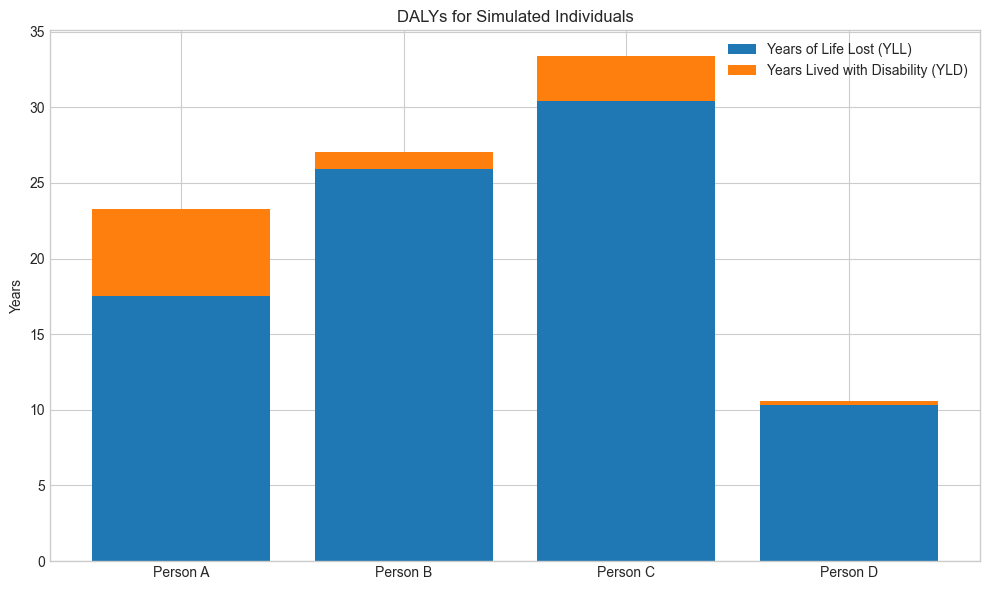

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    df_individual["Person"],
    df_individual["YLL"],
    label="Years of Life Lost (YLL)"
)

ax.bar(
    df_individual["Person"],
    df_individual["YLD"],
    bottom=df_individual["YLL"],
    label="Years Lived with Disability (YLD)"
)

ax.set_ylabel("Years")
ax.set_title("DALYs for Simulated Individuals")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:


# Example people structure (adjust to your actual list)
people = [
    {"id": "Person A", "age_at_death": 45, "years_with_condition": 10, "dw": get_dw("Moderate major depressive disorder")},
    {"id": "Person B", "age_at_death": 75, "years_with_condition": 20, "dw": get_dw("Moderate low back pain with leg pain")},
    {"id": "Person C", "age_at_death": 30, "years_with_condition":  1, "dw": get_dw("Vitamin A deficiency, with blindness")},
    {"id": "Person D", "age_at_death": 85, "years_with_condition": 15, "dw": get_dw("Uncomplicated diabetes mellitus type 2")},
]

rows = []
for p in people:
    age = p["age_at_death"]
    t = p["years_with_condition"]
    dw = p["dw"]

    # Simple assumption for teaching: condition starts t years before death
    dfl_years = max(age - t, 0)                 # years lived disability-free
    lived_with_disability_healthy = t * (1 - dw)
    yld = t * dw

    # YLL from the reference life table (remaining LE at age of death)
    yll = get_life_expectancy(age)

    reference_endpoint = age + yll

    rows.append({
        "Person": p["id"],
        "DFL (years lived disability-free)": dfl_years,
        "Healthy lived (during disability)": lived_with_disability_healthy,
        "YLD (healthy years lost)": yld,
        "YLL (years of life lost)": yll,
        "Reference endpoint age": reference_endpoint,
    })

df = pd.DataFrame(rows)

# ---- Plot (horizontal stacked bars read better) ----
fig, ax = plt.subplots(figsize=(10, 6))

y = np.arange(len(df))

left = np.zeros(len(df))
ax.barh(y, df["DFL (years lived disability-free)"], left=left, label="DFL (lived, disability-free)")
left += df["DFL (years lived disability-free)"]

ax.barh(y, df["Healthy lived (during disability)"], left=left, label="Healthy lived (during disability)")
left += df["Healthy lived (during disability)"]

ax.barh(y, df["YLD (healthy years lost)"], left=left, label="YLD (healthy-equivalent loss)")
left += df["YLD (healthy years lost)"]

ax.barh(y, df["YLL (years of life lost)"], left=left, label="YLL (loss due to premature death)")

ax.set_yticks(y)
ax.set_yticklabels(df["Person"])
ax.set_xlabel("Years (stacked to the GBD reference endpoint)")
ax.set_title("Life course decomposition to reference endpoint: DFL → disability → YLD → YLL")
ax.legend()

plt.tight_layout()
plt.show()

display(df[[
    "Person",
    "Reference endpoint age",
    "DFL (years lived disability-free)",
    "Healthy lived (during disability)",
    "YLD (healthy years lost)",
    "YLL (years of life lost)",
]].round(2))


## 4. The Disability Weight Exercise

### 4.1 How GBD Determines Disability Weights

The Global Burden of Disease study uses **paired comparisons** from population surveys. Respondents are presented with two hypothetical health states and asked which they consider healthier.

### 4.2 Other elicitation methods (and why they differ)

Different elicitation methods often produce systematically different values for the same health state.

- **Visual analogue scale (VAS):** respondents place a health state on a line (for example 0 = death, 100 = full health). This is simple, but it is sensitive to anchoring and does not enforce an explicit trade-off.
- **Time trade-off (TTO):** respondents trade length of life for quality of life (for example, 10 years in a health state is equivalent to *x* years in full health). This enforces a quantity–quality trade, but results depend on the time horizon and attitudes to death.
- **Standard gamble (SG):** respondents choose between a certain impaired health state and a gamble between full health and immediate death. This incorporates risk and is influenced by risk aversion.
- **Person trade-off (PTO):** respondents trade benefits across people (for example, curing 100 people of A versus curing *y* people of B). This resembles policy choices but mixes severity with moral judgements about distribution.

**Utilities and negative values:** in some QALY valuation systems, a health state can be valued as worse than death, producing negative utilities. Disability weights used in DALYs are bounded between 0 and 1; they do not take negative values.



### 4.3 Mini-exercise: VAS versus TTO for one health state

In this mini-exercise you will value one health state using two methods:

- VAS: you place the state on a 0–100 scale
- TTO: you indicate how many years in full health are equivalent to 10 years in the state

We convert to a disability weight using:
$$DW = 1 - u$$
where $u$ is the implied utility.

In [ ]:
# Choose one condition for the method comparison
condition_name = "Moderate major depressive disorder"
gbd_dw = get_dw(condition_name)
gbd_u = 1 - gbd_dw

print(f"Condition: {condition_name}")
print(f"GBD disability weight (DW): {gbd_dw:.3f}  |  implied utility (1-DW): {gbd_u:.3f}")

In [ ]:
# Interactive comparison: VAS and TTO

vas = widgets.IntSlider(
    value=70, min=0, max=100, step=1,
    description="VAS (0–100):",
    continuous_update=False
)

tto = widgets.FloatSlider(
    value=8.0, min=0.0, max=10.0, step=0.1,
    description="TTO (years):",
    continuous_update=False
)

out = Output()

def update_display(change=None):
    with out:
        out.clear_output(wait=True)

        # VAS utility and DW
        u_vas = vas.value / 100
        dw_vas = 1 - u_vas

        # TTO utility and DW (10-year horizon)
        u_tto = tto.value / 10
        dw_tto = 1 - u_tto

        df = pd.DataFrame(
            {
                "Method": ["VAS", "TTO (10-year horizon)", "GBD (reference)"],
                "Utility (u)": [u_vas, u_tto, 1 - gbd_dw],
                "Disability weight (DW = 1-u)": [dw_vas, dw_tto, gbd_dw],
            }
        )

        display(df.style.format({"Utility (u)": "{:.3f}", "Disability weight (DW = 1-u)": "{:.3f}"}))

for w in [vas, tto]:
    w.observe(update_display, names="value")

update_display()
display(VBox([widgets.HTML("<b>Set values and compare:</b>"), vas, tto, out]))

In [ ]:
# Display conditions for students to consider
print("DISABILITY WEIGHT EXERCISE")
print("=" * 80)
print("\nAssign a disability weight (0-1) to each condition below.")
print("0 = perfect health, 1 = equivalent to death")
print("-" * 80)

for i, c in enumerate(EXERCISE_CONDITIONS, 1):
    print(f"\n{i}. {c['name'].upper()}")
    print(f"   {c['description']}")

In [ ]:
# Interactive widget for setting disability weights
sliders = {}
slider_widgets = []

for c in EXERCISE_CONDITIONS:
    slider = FloatSlider(
        value=0.1, min=0, max=1, step=0.01,
        description='',
        continuous_update=False,
        readout_format='.2f',
        layout=widgets.Layout(width='300px')
    )
    sliders[c['name']] = slider
    label = widgets.HTML(value=f"<b>{c['name']}</b>", layout=widgets.Layout(width='200px'))
    slider_widgets.append(HBox([label, slider]))

output = Output()

def compare_weights(change=None):
    with output:
        output.clear_output(wait=True)
        
        comparison_data = []
        for c in EXERCISE_CONDITIONS:
            your_weight = sliders[c['name']].value
            gbd_weight = c['gbd_weight']
            comparison_data.append({
                'Condition': c['name'],
                'Your Weight': your_weight,
                'GBD Weight': gbd_weight,
                'Difference': your_weight - gbd_weight
            })
        
        df = pd.DataFrame(comparison_data)
        
        # Create comparison plot
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df))
        width = 0.35
        
        ax.bar(x - width/2, df['Your Weight'], width, label='Your weights', color='steelblue')
        ax.bar(x + width/2, df['GBD Weight'], width, label='GBD weights', color='coral')
        
        ax.set_ylabel('Disability Weight')
        ax.set_title('Your Disability Weights vs GBD 2019')
        ax.set_xticks(x)
        ax.set_xticklabels(df['Condition'], rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0, 1)
        plt.tight_layout()
        plt.show()
        
        print("\nComparison Table:")
        display(df.style.format({
            'Your Weight': '{:.3f}',
            'GBD Weight': '{:.3f}',
            'Difference': '{:+.3f}'
        }).background_gradient(subset=['Difference'], cmap='RdYlGn_r', vmin=-0.3, vmax=0.3))

for slider in sliders.values():
    slider.observe(compare_weights, names='value')

compare_button = widgets.Button(description="Compare to GBD", button_style='primary')
compare_button.on_click(compare_weights)

print("Adjust the sliders to set your disability weights, then click 'Compare to GBD':")
display(VBox(slider_widgets + [compare_button, output]))

### 4.3 Your Turn: Set Your Own Disability Weights

Assign your own disability weights to a set of conditions, then compare to GBD values.

In [ ]:
# Display conditions for students to consider
print("DISABILITY WEIGHT EXERCISE")
print("=" * 80)
print("\nAssign a disability weight (0–1) to each condition below.")
print("0 = full health, 1 = equivalent to death")
print("-" * 80)

for i, c in enumerate(EXERCISE_CONDITIONS, 1):
    print(f"\n{i}. {c['name'].upper()}")
    print(f"   {c['description']}")

In [ ]:
# Interactive widget for setting disability weights

sliders = {}
slider_widgets = []

for c in EXERCISE_CONDITIONS:
    slider = FloatSlider(
        value=0.10, min=0.0, max=1.0, step=0.01,
        description="",
        continuous_update=False,
        readout_format=".2f",
        layout=widgets.Layout(width="320px")
    )
    sliders[c["name"]] = slider
    label = widgets.HTML(value=f"<b>{c['name']}</b>", layout=widgets.Layout(width="220px"))
    slider_widgets.append(HBox([label, slider]))

output = Output()

def compare_weights(change=None):
    with output:
        output.clear_output(wait=True)

        comparison_data = []
        for c in EXERCISE_CONDITIONS:
            your_weight = sliders[c["name"]].value
            gbd_weight = c["gbd_weight"]
            comparison_data.append(
                {
                    "Condition": c["name"],
                    "Your weight": your_weight,
                    "GBD weight": gbd_weight,
                    "Difference (you - GBD)": your_weight - gbd_weight,
                }
            )

        df = pd.DataFrame(comparison_data)

        # Simple plot without hard-coded colours
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df))
        width = 0.40

        ax.bar(x - width/2, df["Your weight"], width, label="Your weights")
        ax.bar(x + width/2, df["GBD weight"], width, label="GBD weights")

        ax.set_ylabel("Disability weight")
        ax.set_title("Your disability weights versus GBD 2019")
        ax.set_xticks(x)
        ax.set_xticklabels(df["Condition"], rotation=45, ha="right")
        ax.set_ylim(0, 1)
        ax.legend()
        plt.tight_layout()
        plt.show()

        display(
            df.style.format(
                {"Your weight": "{:.3f}", "GBD weight": "{:.3f}", "Difference (you - GBD)": "{:+.3f}"}
            )
        )

for slider in sliders.values():
    slider.observe(compare_weights, names="value")

compare_button = widgets.Button(description="Compare to GBD")
compare_button.on_click(compare_weights)

print("Adjust the sliders, then click 'Compare to GBD':")
display(VBox(slider_widgets + [compare_button, output]))

### 4.5 Discussion Questions

1. **Where did you differ most from GBD?** Why might your valuation differ?

2. **Adaptation**: People living with a condition often rate it less severe. Whose values should count?

3. **Cultural variation**: Might conditions be valued differently across cultures?

4. **The "worse than death" problem**: GBD caps weights at 1.0. How should we handle states some consider worse than death?

## 5. How Disability Weights Change Rankings

Let's see how your disability weights would change burden rankings.

In [ ]:
# Hypothetical prevalence data
population_data = {
    'Mild anaemia': {'prevalence': 500000, 'deaths_by_age': {}},
    'Moderate hearing loss': {'prevalence': 300000, 'deaths_by_age': {}},
    'Moderate depression': {'prevalence': 150000, 'deaths_by_age': {45: 50, 55: 30, 65: 20}},
    'Severe low back pain': {'prevalence': 100000, 'deaths_by_age': {}},
    'Complete blindness': {'prevalence': 30000, 'deaths_by_age': {}},
    'Severe dementia': {'prevalence': 80000, 'deaths_by_age': {75: 2000, 85: 5000}},
    'Type 2 diabetes (controlled)': {'prevalence': 400000, 'deaths_by_age': {55: 100, 65: 500, 75: 1000, 85: 500}},
    'Obesity (BMI ≥ 40)': {'prevalence': 200000, 'deaths_by_age': {45: 50, 55: 200, 65: 300, 75: 200}}
}

def calculate_burden_rankings(population_data, disability_weights):
    results = []
    for condition, data in population_data.items():
        dw = disability_weights.get(condition, 0.1)
        yll = 0
        if data['deaths_by_age']:
            yll, _ = calculate_yll(data['deaths_by_age'])
        yld = calculate_yld(data['prevalence'], dw)
        dalys = yll + yld
        results.append({'Condition': condition, 'DW': dw, 'YLL': yll, 'YLD': yld, 'DALYs': dalys})
    
    df = pd.DataFrame(results).sort_values('DALYs', ascending=False)
    df['Rank'] = range(1, len(df) + 1)
    return df[['Rank', 'Condition', 'DW', 'YLL', 'YLD', 'DALYs']]

In [ ]:
# Calculate rankings with GBD weights
gbd_weights = {c['name']: c['gbd_weight'] for c in EXERCISE_CONDITIONS}
gbd_rankings = calculate_burden_rankings(population_data, gbd_weights)

print("Disease Burden Rankings using GBD Disability Weights")
print("=" * 80)
display(gbd_rankings.style.format({'DW': '{:.3f}', 'YLL': '{:,.0f}', 'YLD': '{:,.0f}', 'DALYs': '{:,.0f}'}))

In [ ]:
# Calculate rankings with YOUR weights
your_weights = {name: slider.value for name, slider in sliders.items()}
your_rankings = calculate_burden_rankings(population_data, your_weights)

print("Disease Burden Rankings using YOUR Disability Weights")
print("=" * 80)
display(your_rankings.style.format({'DW': '{:.3f}', 'YLL': '{:,.0f}', 'YLD': '{:,.0f}', 'DALYs': '{:,.0f}'}))

## 6. DALYs vs QALYs

| Aspect | DALY | QALY |
|--------|------|------|
| **Direction** | Higher = more burden | Higher = more health |
| **Primary use** | Population burden estimation | Cost-effectiveness analysis |
| **Key user** | GBD, WHO | NICE, health economists |

In [ ]:
# Example: Cataract surgery
qalys, utility_gain = calculate_qalys_gained(
    intervention_effect=0.95,
    population=10000,
    duration=15,
    dw_before=0.187,
    dw_after=0.003
)

print("Cataract Surgery Programme")
print("=" * 50)
print(f"Population: 10,000 people with cataracts")
print(f"Success rate: 95%")
print(f"Duration of benefit: 15 years")
print(f"\nUtility gain per person: {utility_gain:.3f}")
print(f"Total QALYs gained: {qalys:,.0f}")
print(f"\nIf programme costs £10M: £{10000000/qalys:,.0f} per QALY")
print(f"NICE threshold: £20,000-£30,000 per QALY")

## 7. Limitations and Critique

### The Disability Rights Critique

Some argue that QALYs/DALYs discriminate against disabled people.

In [ ]:
# Illustration: The discrimination problem
print("The QALY Discrimination Problem")
print("=" * 60)
print("\nScenario: A life-saving treatment adding 10 years of life.\n")

qalys_nondisabled = 10 * (1 - 0)
print(f"Patient A (no disability): 10 years × 1.0 = {qalys_nondisabled:.1f} QALYs\n")

qalys_disabled = 10 * (1 - 0.133)
print(f"Patient B (paraplegia, DW=0.133): 10 years × 0.867 = {qalys_disabled:.1f} QALYs\n")

print("-" * 60)
print(f"Patient A's life is valued {qalys_nondisabled/qalys_disabled:.1%} as much as Patient B's.")
print(f"\nIs this fair?")

## 8. Exercises

### Exercise 1: Calculate DALYs for Iron Deficiency Anaemia

Data (hypothetical UK population):
- Mild anaemia: 800,000 (DW=0.004)
- Moderate anaemia: 150,000 (DW=0.052)
- Severe anaemia: 20,000 (DW=0.149)
- Deaths: 500 at age 75, 1000 at age 85

In [ ]:
# YOUR CODE HERE



### Exercise 2: Reflection Questions

1. The GBD weight for obesity (0.086) is lower than for depression (0.145). Do you agree?

2. Should DALYs include age-weighting (valuing years in middle-age more)? Why did GBD remove this?

3. How might you measure the burden of poor diet without relying on disease categories?

---

## References

- GBD 2019 Diseases and Injuries Collaborators. (2020). *The Lancet*.
- Salomon JA et al. (2015). Disability weights for GBD 2013. *Lancet Global Health*.
- Nord E. (2015). Limitations of the QALY. *Cambridge Quarterly of Healthcare Ethics*.